In [35]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [36]:
def sin_wave(A, omega, fai, length):
	# A*sin(ωt - φ)
	x = np.linspace(0, 2*np.pi*(length/omega), length)
	return A*np.sin(x - fai)
def cos_wave(A, omega, fai, length):
	# A*cos(ωt - φ)
	x = np.linspace(0, 2*np.pi*(length/omega), length)
	return A*np.cos(x - fai)

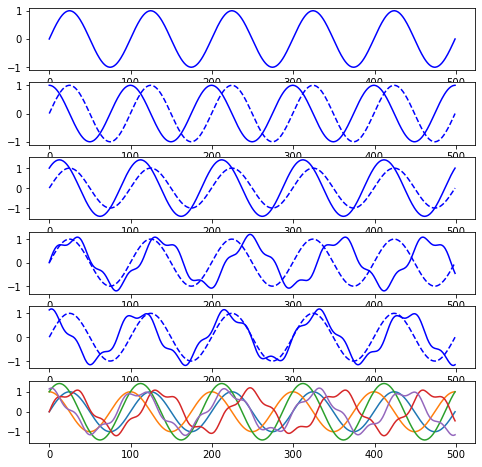

In [37]:
x1 = sin_wave(1, 100, 0, 500)
x2 = cos_wave(1, 100, 0, 500)
x3 = sin_wave(1, 100, 0, 500) + cos_wave(1, 100, 0, 500)
x4 = sin_wave(1, 110, 0, 500) + sin_wave(0.2, 30, 0, 500)
x5 = cos_wave(1, 110, 0, 500) + sin_wave(0.2, 30, -np.pi/4, 500)
X = np.array([x1,x2,x3,x4,x5]).T

plt.figure(figsize=(8,8))
plt.subplot(611)
plt.plot(x1,color='b')
plt.subplot(612)
plt.plot(x2,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(613)
plt.plot(x3,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(614)
plt.plot(x4,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(615)
plt.plot(x5,color='b')
plt.plot(x1,color='b',linestyle='dashed')
plt.subplot(616)
plt.plot(X)

In [38]:
def heatmap_plot(X):
	fig = plt.figure()
	plt.figure(figsize=(8,8))
	ax1 = fig.add_subplot(521)
	ax1.plot(x1,color='b')
	ax2 = fig.add_subplot(523)
	ax2.plot(x2,color='b')
	ax2.plot(x1,color='b',linestyle='dashed')
	ax3 = fig.add_subplot(525)
	ax3.plot(x3,color='b')
	ax3.plot(x1,color='b',linestyle='dashed')
	ax3 = fig.add_subplot(527)
	ax3.plot(x4,color='b')
	ax3.plot(x1,color='b',linestyle='dashed')
	ax4 = fig.add_subplot(529)
	ax4.plot(x5,color='b')
	ax4.plot(x1,color='b',linestyle='dashed')

	ax5 = fig.add_subplot(122)
	ax5.imshow(X, cmap='binary')

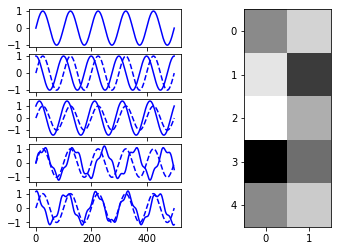

<Figure size 576x576 with 0 Axes>

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
feature = pca.fit_transform(X.T)
heatmap_plot(feature)

In [40]:
from pykalman import KalmanFilter

class LDS:
	def __init__(self, n_dim_state, n_dim_obs):
		n_dim_state = n_dim_state
		n_dim_obs = n_dim_obs

		self.miu = np.random.rand(n_dim_state)
		self.A = np.eye(n_dim_state, n_dim_state)+ np.random.rand(n_dim_state, n_dim_state)
		self.C = np.eye(n_dim_obs, n_dim_state)+ np.random.rand(n_dim_obs, n_dim_state)
		self.Q = np.eye(n_dim_state, n_dim_state)
		self.R = np.eye(n_dim_obs, n_dim_obs)

	def fit(self, X):
		kf = KalmanFilter( initial_state_mean=self.miu,
						initial_state_covariance=self.Q,
						transition_matrices=self.A,
						transition_covariance=self.Q,
						observation_matrices=self.C,
						observation_covariance=self.R)
			
		kf.em(X,em_vars=['transition_matrices','transition_covariance', 'observation_matrices','observation_covariance'],n_iter=10)
		self.A = kf.transition_matrices
		self.C = kf.observation_matrices


In [41]:
lds = LDS(n_dim_state=6,n_dim_obs=5)
lds.fit(X)
heatmap_plot(lds.C)

In [ ]:
from sklearn.decomposition import TruncatedSVD

class PLiF:
	def __init__(self, X, n_dim_obs=0, n_dim_state=0, k=2):
		self.X = X
		if n_dim_state==0:
			self.n_dim_state = _choose_h() 
		else:
			self.n_dim_state = n_dim_state
		if n_dim_obs==0:
			self.n_dim_obs = self.X.shape[1]
		else:
			self.n_dim_obs = n_dim_obs
		self.k = k

	def _choose_h(self):
		reconstructio_rate = 0.95
		U, s, V = np.linalg.svd(self.X, full_matrices=False)
		S = np.diag(s)

		sigma_s=0
		for i in range(len(s)):
			sigma_s += s[i]
			if sigma_s/sum(s) > reconstructio_rate:
				h = i
				break
		return h

	def fit_lds(self):
		lds = LDS(n_dim_state=self.n_dim_state,n_dim_obs=self.n_dim_obs)
		lds.fit(self.X)
		self.A = lds.A
		self.C = lds.C

	def fit(self):
		self.fit_lds()
		V, Are, V_inv = eigen_decomposition(self.A)
		self.V = V
		self._harmonic_mixing()
		self._handling_lag()
		self._grouping_harmonics()

	def _harmonic_mixing(self):
		self.Ch = np.dot(self.C, self.V)

	def _handling_lag(self):
		self.Cm = abs(self.Ch)

	def _grouping_harmonics(self):
		# Cm_ = Cm - mean(Cm)
		# Cm_ ~= U * S * V  (SVD)
		# F  = U * S
		k=self.k
		Cm_ = self.Cm - np.mean(self.Cm)
		U, s, V = np.linalg.svd(Cm_, full_matrices=False)
		S = np.diag(s)

		self.F = np.dot(U[:, :k], S[:k, :k])

		#Use TruncatedSVD
		# k=self.k
		# Cm_ = self.Cm - np.mean(self.Cm)
		# svd = TruncatedSVD(k)
		# self.F = svd.fit_transform(Cm_)




def eigen_decomposition(A):
	#A = V D V.inv
	d, V = np.linalg.eig(A) #d: eigen value, V: eigen vector
	D = np.diag(d)
	V_inv = np.linalg.inv(V)
	return V, D, V_inv


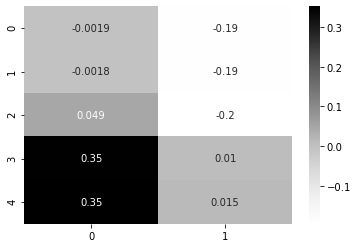

In [ ]:
plif = PLiF(X, n_dim_obs=5, n_dim_state=6, k=2)
plif.fit()
import seaborn as sns
sns.heatmap(data=plif.F, annot=True, cmap='Greys',)

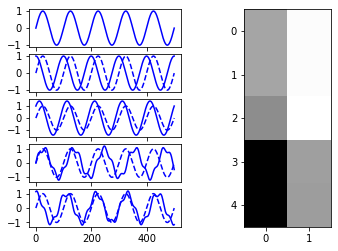

<Figure size 576x576 with 0 Axes>

In [ ]:
heatmap_plot(plif.F)

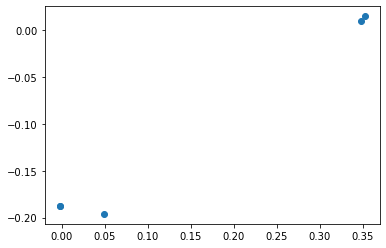

In [ ]:
plt.scatter(plif.F[:,0], plif.F[:,1])